# Matrix completion and recommender systems

[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.
 
This data set consists of:
- 100000 ratings (1-5) from 943 users on 1682 movies. 
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly              ordered. This is a tab separated list of 

```
user id | item id | rating | timestamp
```

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

Read the dataset from the `movielens.csv` file.

In [ ]:
dataset = pd.read_csv('movielens.csv', sep = '\t', header = None)
dataset.describe() #4 columns=> we consider only the first 3
#columns and rows start from 1

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


As we can see in table above, the min value is 1. Since each column of dataset contains indexes(the ones for the users, the movies e ratings), we want them to start from 0 as always... so when we convert the columns in numpy arrays we subtract 1

How many movies? How many people? How many ratings?

In [ ]:
rows = np.array(dataset[0]) - 1
cols = np.array(dataset[1]) - 1
vals = np.array(dataset[2]) 

n = rows.max() + 1 # because the max value is the index not the dimension => we have to sum up one
p = cols.max() + 1
N = len(vals)

print('%d users' % n)
print('%d movies' % p)
print('%d ratings' % N)

943 users
1682 movies
100000 ratings


Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).

In [ ]:
indexes = np.arange(N)
np.random.seed(1) # for reproducibility
#seed allows to have the same random shuffle every time
np.random.shuffle(indexes)
indexes
rows = rows[indexes]
cols = cols[indexes]
vals = vals[indexes]

Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.

In [ ]:
#training split
num_training = 80000
rows_train = rows[:num_training]
cols_train = cols[:num_training]
vals_train = vals[:num_training]

#test split
rows_test  = rows[num_training:]
cols_test  = cols[num_training:]
vals_test  = vals[num_training:]

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $j$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:
$$
X_{i,j} = 
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$

In [ ]:
#To build a matrix with rows,cols indexes and ratings in position (i,j)
X = csr_matrix((vals_train, (rows_train, cols_train)), shape=(n, p))
#convert in a ful matrix
X = X.toarray()

X2 = np.zeros((n,p))
X2[rows_train, cols_train] = vals_train

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:
$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$
where $N_i = card(j : (i,j) \in \Omega)$.

Then compute the RMSE (root mean square error):
$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$
and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):
$$
\rho = 
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}} 
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$
where
$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} 
       r_{ij} 
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} 
       r^{\text{pred}}_{ij} 
\end{split}
$$

In [ ]:
i_user = 0
# rows_train == i_user #I get true only when that user have given a rating to a movie in that position
# vals_train[rows_train == i_user] #I get all the ratings gien by that user
np.mean(vals_train[rows_train == i_user]) #I get the average rating of the given user

3.6216216216216215

In [ ]:
#all the average ratings of each user
avg_ratings = np.array([np.mean(vals_train[rows_train == i_user]) for i_user in range(n)])
#predicted values by the trivial recomended system
vals_trivial = avg_ratings[rows_test] #simply put the avg rating where we do not have a rating

err_trivial = vals_test - vals_trivial #error: real value - the trivial value

RMSE_trivial = np.sqrt(np.mean(err_trivial**2)) #RMSE error
rho_trivial = pearsonr(vals_test, vals_trivial)[0] #pearson error

print('RMSE: %1.3f' % RMSE_trivial)
print('rho : %1.3f' % rho_trivial)

RMSE: 1.043
rho : 0.384


# Singular value truncation (SVT) based recommender system

Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration. Finally, plot the trend of both metrics.

Try to calibrate the threshold to get better results.

In [ ]:
n_max_iter = 100
threshold = 100.0
increment_tol = 1e-2

#list to append the values and then plot them
RMSE_list = list()
rho_list = list()

X_hat = X

for k in range(n_max_iter):
  X_old = X_hat.copy() #copy to be sure we are copying the value 
  
  U,s,VT = np.linalg.svd(X_hat, full_matrices=False) #svd decomposition each time
  
  s[s < threshold] = 0 #put 0 on the singular value if s<threshold

  X_hat = U @ np.diag(s) @ VT
  X_hat[rows_train,cols_train] = vals_train 
  increment = np.linalg.norm(X_hat - X_old)
  
  #compute the trend of both metrics
  vals_pred = X_hat[rows_test, cols_test]
  err = vals_test - vals_pred
  RMSE = np.sqrt(np.mean(err**2))
  rho = pearsonr(vals_test, vals_pred)[0]
  RMSE_list.append(RMSE)
  rho_list.append(rho)
  print('================== iter %d - increment %1.3e' % (k+1, increment))
  print('RMSE: %1.3f' % RMSE)
  print('rho : %1.3f' % rho)

  if increment < increment_tol:
    break

================== iter 1 - increment 4.308e+02
RMSE: 2.611
rho : 0.314
================== iter 2 - increment 2.581e+02
RMSE: 2.166
rho : 0.342
================== iter 3 - increment 1.843e+02
RMSE: 1.919
rho : 0.364
================== iter 4 - increment 1.433e+02
RMSE: 1.758
rho : 0.381
================== iter 5 - increment 1.171e+02
RMSE: 1.645
rho : 0.395
================== iter 6 - increment 9.887e+01
RMSE: 1.561
rho : 0.407
================== iter 7 - increment 8.547e+01
RMSE: 1.495
rho : 0.417
================== iter 8 - increment 7.521e+01
RMSE: 1.443
rho : 0.426
================== iter 9 - increment 6.711e+01
RMSE: 1.400
rho : 0.433
================== iter 10 - increment 6.056e+01
RMSE: 1.364
rho : 0.440
================== iter 11 - increment 5.516e+01
RMSE: 1.334
rho : 0.445
================== iter 12 - increment 5.063e+01
RMSE: 1.308
rho : 0.451
================== iter 13 - increment 4.678e+01
RMSE: 1.285
rho : 0.455
================== iter 14 - increment 4.347e+01
RMSE: 1.265

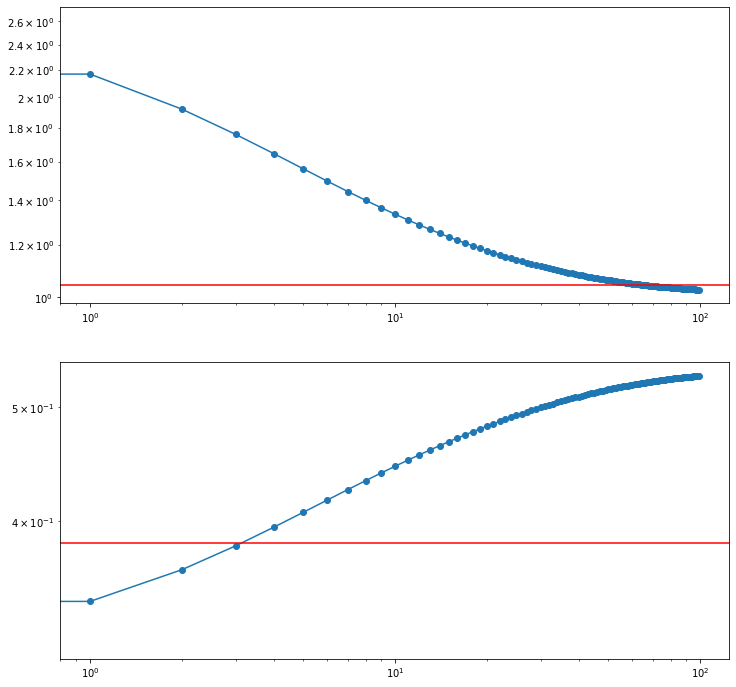

In [ ]:
fig, axs = plt.subplots(2,1,figsize = (12,12))
axs[0].loglog(RMSE_list, 'o-')
axs[0].axhline(RMSE_trivial, color = 'red')
axs[1].loglog(rho_list, 'o-')
axs[1].axhline(rho_trivial, color = 'red')
